#### **NOTEBOOK CONTENT**

In this notebook you will find a preliminary introduction to our experiments, a table of results, and a final part containing code with relative documentation.

The code part of the notebook contains the experiments that we thought were the most relevant to fulfil the task of visual grounding. Here we do not present the full list of experiments, because some did not lead to better performances. They are all stored in [this](https://github.com/r1cc4r2o/visual-grounding-DL23) GitHub repository.
Our solutions are presented in the following order:
- Baseline
- Baseline with rephrasing
- Rephrasing module with training
- BLIP with captioning
- Context Graph Module

The last block of this notebook contains plots and Plug&Play Code for running evaluation (takes ~5 minutes) using preprocessed inferred data.

## Introduction

Given a single image and a single caption. The baseline uses YOLO to extract the bounding boxes (bboxes) of the single objects in the image. The confidence value (also known as the detector score) measures the probability of correctly classifying and detecting the object. We kept the parameter at 0.5 to ensure the right trade-off between the number of bboxes and reliability. Finally, the baseline uses CLIP to extract the features from each image section and compute the match between the features of the target caption. To compute the match in the CLIP latent space, we use cosine similarity (CS)$^{[1]}$. Two vectors in the latent space are orthogonal if the CS is 0. If the CS is -1, those vectors can be considered highly dissimilar, while having CS close to 1 means they are significantly similar. We perform the softmax operation on the vector with the matching scores bboxes-caption. Since the scores sum to 1, we can see the matching scores in probabilistic terms. In the baseline, the predicted bbox is the most likely bbox according to the CS score in the CLIP latent space.

![Imgur](https://i.imgur.com/ZlIbVo9.png)

In our experiments, we found that using different backbones for object detection led to different performances. As we mentioned in the first part, the detector has a large impact on the performance of the overall architecture.

From the experiments we ran with DETR (instead of YOLO), we observed a consistent drop in performance. In fact, DETR typically finds a wider range of objects in the image with a high detection score. We noticed that in most cases when we detected a wider range of objects, the CS scores bboxes-caption seem to be confused. In our opinion, a few of the detected objects are wrongly placed in the CLIP latent space, leading to an unfair matching score, which compromises the entire evaluation score. To solve this problem, it would be possible to change the image-text matching model. For example, instead of using CLIP, one could use BLIP.

Then we increased the confidence value (CV) of the detector to 0.7. This resulted in fewer bboxes being evaluated (those with a higher CV). Reducing the number of bboxes resulted in AP@0.5 going from 0.21 to 0.33.

Due to the large number of YOLO versions available, we tested  those that balanced computational complexity and AP. The ones we used are: yolov5l6, yolov5l6u, yolov5x6u and yolov8x. We report here the table with the performances and the FLOP, which refer to the computational complexity. The u family of yolov5s models has recently been released. These models are the v5 models that incorporate the features available in the v8 family. In addition, they have been further optimised to reduce the computational complexity.

We first did some preliminary experiments to evaluate whether to use the CLIP with or without ViT. This design choice is important. As we said, the more accurate the latent representation of the image parts, the more reliable the matching score. In our preliminary studies, we used grad-cam to investigate which parts of the image are activated for a given $caption^{[2]}$.

![Imgur](https://i.imgur.com/RmmsW18.png)

The results show that we still have problems recognising the object described in the text. As you can see in the image, using a large version of ResNet does not guide the model on focusing on the correct point. Transformers have proven to be the backbone of many SoTA architectures. The architecture using ViT32 has been shown to outperform the traditional CNN $architecture^{[3]}$. In particular, the backbone attention mechanism in ViT32 aims to capture global dependencies. If the goal is to obtain representative coding. Encoding the visual information using CLIP with ViT32 can lead to improved $representations^{[4]}$. This would lead to an improvement in overall performance. However, we do not have unlimited resources to perform multiple evaluations. We decided to use CLIP-ViT/32B. This model seems to be the right compromise between the larger and the smaller model.


Here we report the full table with all the scores obtained with the different backbones. The best results are obtained with the yolov5l6u and yolov8x. We evaluate our method using several backbones as detectors. One of the metrics we use to measure the performance of our method is the mean intersection over union (IoU) between the predicted and ground truth bounding boxes. IoU is a widely used metric for object detection, as it reflects how well the model can align the bounding boxes with the actual objects. We also report the F1 score, accuracy, recall and precision of our method, which are derived from the confusion matrix of true positives, false positives, true negatives and false negatives. These metrics ephatizes how many objects are detected, how many are missed, how many are falsely detected, and how many are correctly detected. These metrics are reported with different IoU thresholds. This allows to analyze how robust our method is to different levels of localization error.

\

<center/>


**TABLE WITH THE METRICS: EVALUATION BASELINE WITH DIFFERENT BACKBONES**

\

|                                  |iou_m|acc@0.3|acc@0.5|acc@0.75|ap@0.3|ap@0.5|ap@0.75|ar@0.3|ar@0.5|ar@0.75|f1@0.3|f1@0.5|f1@0.75|
|---------------------------|------------------|--------------|--------------|---------------|-------------|-------------|--------------|----------|----------|-----------|------------|------------|-------------|
|yolo_v5l6_train            |0.52|0.57          |0.53          |0.51           |0.57         |0.53         |0.51          |0.57      |0.53      |0.51       |0.57        |0.53        |0.51         |
|yolo_v5l6_val              |0.55 |0.6           |0.55          |0.52           |0.6          |0.55         |0.52          |0.6       |0.55      |0.52       |0.6         |0.55        |0.52         |
|yolo_v5l6_test             |0.51|0.56          |0.52          |0.49           |0.56         |0.52         |0.49          |0.56      |0.52      |0.49       |0.56        |0.52        |0.49         |
|yolo_v5l6_1_train_rephrased|0.54|0.58          |0.54          |0.51           |0.58         |0.54         |0.51          |0.58      |0.54      |0.51       |0.58        |0.54        |0.51         |
|yolo_v5l6_1_val_rephrased  |0.55 |0.6           |0.55          |0.51           |0.6          |0.55         |0.51          |0.6       |0.55      |0.51       |0.6         |0.55        |0.51         |
|yolo_v5l6_1_test_rephrased |0.54|0.59          |0.54          |0.5            |0.59         |0.54         |0.5           |0.59      |0.54      |0.5        |0.59        |0.54        |0.5          |
|yolo_v5l6u_train           |0.55 |0.59          |0.55          |0.52           |0.59         |0.55         |0.52          |0.59      |0.55      |0.52       |0.59        |0.55        |0.52         |
|yolo_v5l6u_val             |0.56|0.62          |0.57          |0.53           |0.62         |0.57         |0.53          |0.62      |0.57      |0.53       |0.62        |0.57        |0.53         |
|yolo_v5l6u_test            |0.54|0.58          |0.54          |0.51           |0.58         |0.54         |0.51          |0.58      |0.54      |0.51       |0.58        |0.54        |0.51         |
|yolo_v5x6u_test            |0.55 |0.59          |0.55          |0.51           |0.59         |0.55         |0.51          |0.59      |0.55      |0.51       |0.59        |0.55        |0.51         |
|yolo_v8x_train             |0.55|0.59          |0.55          |0.52           |0.59         |0.55         |0.52          |0.59      |0.55      |0.52       |0.59        |0.55        |0.52         |
|yolo_v8x_val               |0.56|0.61          |0.56          |0.53           |0.61         |0.56         |0.53          |0.61      |0.56      |0.53       |0.61        |0.56        |0.53         |
|yolo_v8x_test              |0.55 |0.59          |0.55          |0.52           |0.59         |0.55         |0.52          |0.59      |0.55      |0.52       |0.59        |0.55        |0.52         |

</center>

\

---
1. https://en.wikipedia.org/wiki/Cosine_similarity
2. https://colab.research.google.com/github/kevinzakka/clip_playground/blob/main/CLIP_GradCAM_Visualization.ipynb
3. https://arxiv.org/abs/2010.11929
4. https://sh-tsang.medium.com/review-attention-is-all-you-need-transformer-96c787ecdec1


Visual grounding is a fundamental problem in computer vision that aims to establish a correspondence between textual descriptions and visual content.The goal of the task is to locate specific objects or regions in an image that correspond to a given textual description. Recent advances in deep learning and natural language processing have led to new state-of-the-art solutions.

We explored different existing approaches, and we took something from many of them:

1. $MDETR^{[3]}$ proposes a new end-to-end modulated detector that detects objects in an image based on a raw text query. The model uses a transformer-based architecture to fuse text and image modalities, achieving state-of-the-art sentence grounding results. $MDETR^{[3]}$ is built on $DETR^{[2]}$ for object detection. The paper also shows that good modulated and tailored detection performance naturally converges to excellent performance in the visual grounding task. To demonstrate the effectiveness of $MDETR^{[3]}$, the authors tested it on several benchmarks (using Flickr30k, RefCOCO/+, RefCOCOg, ...). Specifically, they used a Hungarian matching loss to guide the model to better performance. The $MDETR^{[3]}$ architecture, without relying on black-box object detectors, can ground the object on a given set.


2. $DQ-DETR$: an improvement of MDETR. The architecture uses ResNet-101 as the backbone. As shown in the figure below, it achieved a top 1 score in the visual grounding task. Here we have reported the table with the results on RefCOCO. The authors found that $DQ-DETR^{[4]}$ outperformed methods combining deep learning with NLP for the grounding task. The backbone of the architecture extracts image and text features. These information are then concatenated and processed using Transformer encoder layers. This mechanism partially inspired us in the concatenation of image crops and text features in the rephrasing architecture with training. The authors combined the L1 and the GIoU loss to perform bounding box regression. Similarly, our proposed architecture uses a combination between the SmoothL1 loss and IoU. This objective function shows the real distance and the accuracy between the prediction and the ground truth.

3. $TreePrompt^{[1]}$ performs prompt matching. Given a sentence and an image, the sentence is parsed to obtain a tree. The tree form identifies structural relationships between entities. The authors of TreePrompt aimed to introduce interpretability. The model achieved comparable performance to the black box models.


---
1. http://arxiv.org/abs/2305.11497
2. https://arxiv.org/abs/2005.12872
3. http://arxiv.org/abs/2104.12763
4. http://arxiv.org/abs/2211.15516

##### **Discussion on performances**
We note that to achieve good performance, the model should perform two tasks. The first is to find the bounding box of each object. The second is to measure the match between the found objects and the textual prompt. The visual matching task can then be performed with CLIP with remarkable results. To achieve higher accuracy score on a given dataset, the detector should match the bounding boxes of the target data. With the detected bbox, we guess which is the best matching one by performing image-text matching in CLIP's fashion. However, if the bbox given by the detector is inaccurate, the performance will be lower. Furthermore, captions may describe multiple objects detected in different bboxes. In the baseline, we are not able to merge objects into a single bounding box, even with a perfect image-text matching model. The performance of the model is then affected by the bboxes found by the detector. To reduce this weakness and to be more robust, we decided to design a mechanism based on the image-text matching scores (image-crops & caption). The image-text matching scores guide a linear layer to perform congruent cropping resize.

## Results

#### **Performance metrics for each model**

In this section, we present the results of our experiments on the RefCOCOg dataset. We compare the performance of our proposed methods with the baseline. For each model, we report the average precision (AP) with different threshold values. The threshold is a parameter that determines how confident the model must be before making a prediction. A higher threshold means that the model is more selective, but also more prone to miss some relevant instances. A lower threshold means that the model is more inclusive, but also more likely to produce false positives. We use the AP and F1 score as evaluation metrics because they capture both the precision and recall of the model, which are important aspects. Each section contains an exhaustive table with all the metrics for each backbone combination.

\

---
<p>
<font size=4><b>Note:</b></br>
We decided to test our training-free solutions on all the dataset splits (train/val/test), for the only reason that a bigger dataset might be more representative. For the BLIP solution we tested only on the test split, as its evaluation was already an onerous task (~5 hours/5000 samples).</font></p>

---

\

Here follows a table containing the performances achieved on the test split for all of our solutions.

\

<center/>

|  Models 	| Avg IoU   	|   AP@0.3	|  AP@0.5 	|  AP@0.75 	|  PARAMS 	|
|---|---|---|---|---|---|
| Baseline  	                   |0.55|0.59|0.55|0.52|151 M|
| Baseline with rephrasing       |0.54|0.59|0.54|0.50|374 M|
| Rephrasing module with training|**0.57**|**0.61**|**0.56**|**0.53**|378 M|
| BLIP with captioning  	       |0.39|0.48 |0.43  | 0.41 |401 M|
| Context Graph Module  	       |**0.57**|0.60|0.55|**0.53**|151 M|

</center>

\


## Code part

### 0 - REQUIRED PACKAGES

In [1]:
%%bash
pip install -qqq gdown
pip install -qqq torch
pip install -qqq pytorch-lightning
pip install -qqq ultralytics
pip install -qqq ftfy regex tqdm
pip install -qqq git+https://github.com/openai/CLIP.git
pip install -qqq transformers==4.29
pip install -qqq sentencepiece==0.1.97

### 1 - DATASET

#### 1.1 - Download dataset

In [ ]:
# Download dataset from Google Drive
!gdown 1tkTUpbdkPqQ1JgHcVlsT0ikjcftF4P6x

In [ ]:
%%bash
unzip /content/refcocog.tar.zip
rm /content/refcocog.tar.zip

In [ ]:
%%bash
# Un-tar dataset and then remove tar file
tar -xvf /content/refcocog.tar
rm /content/refcocog.tar

#### 1.2 - Dataset class

In [1]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

In [2]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

#### 1.3 - Dataloader

{'file_name': './refcocog/images/COCO_train2014_000000519404.jpg', 'caption': 'Two woman one in black eatting and the other has a white shirt at the desk', 'ann_id': 1241542, 'bbox': [0.0, 45.95, 238.92, 408.64]}
---------------------------------------------------
(tensor([[[[0.3725, 0.3412, 0.3922,  ..., 0.0510, 0.0471, 0.0471],
          [0.3882, 0.3490, 0.3765,  ..., 0.0431, 0.0392, 0.0353],
          [0.3686, 0.4078, 0.3922,  ..., 0.0431, 0.0392, 0.0353],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3686, 0.3373, 0.3882,  ..., 0.0510, 0.0471, 0.0471],
          [0.3843, 0.3451, 0.3804,  ..., 0.0431, 0.0392, 0.0353],
          [0.3725, 0.4118, 0.3961,  ..., 0.0431, 0.0392, 0.0353],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

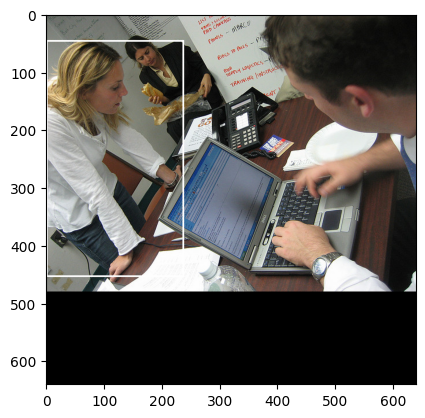

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw

def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    pad_width = padded_width - original_width
    pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0)

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]
    return images, data

transform = transforms.Compose([
    transforms.ToTensor(),
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="train")
print(dataset[0])
print("---------------------------------------------------")
#plt.imshow(Image.open(dataset[2]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)


### Usage:

for d in dataloader:
    print(d)
    img = np.array(d[0][0].cpu().numpy().transpose(1, 2, 0)*255, dtype=np.uint8)
    bbox = d[1]["bbox"][0]
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)
    draw.rectangle(((bbox[0], bbox[1]), (bbox[2]+bbox[0], bbox[3]+bbox[1])), width=3)

    plt.imshow(img)
    plt.show()
    break

In [7]:
for batch,(inputs,outputs) in enumerate(dataloader):
    print(inputs)
    print("-----------")
    print(outputs)
    break

tensor([[[[0.3725, 0.3412, 0.3922,  ..., 0.0510, 0.0471, 0.0471],
          [0.3882, 0.3490, 0.3765,  ..., 0.0431, 0.0392, 0.0353],
          [0.3686, 0.4078, 0.3922,  ..., 0.0431, 0.0392, 0.0353],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3686, 0.3373, 0.3882,  ..., 0.0510, 0.0471, 0.0471],
          [0.3843, 0.3451, 0.3804,  ..., 0.0431, 0.0392, 0.0353],
          [0.3725, 0.4118, 0.3961,  ..., 0.0431, 0.0392, 0.0353],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3490, 0.3176, 0.3686,  ..., 0.0431, 0.0392, 0.0392],
          [0.3647, 0.3255, 0.3569,  ..., 0.0353, 0.0314, 0.0275],
          [0.3490, 0.3882, 0.3725,  ..., 0

### 2 - BASELINE

In [ ]:
import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class YoloClip():
    def __init__(self):

        self.yolo = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True)
        self.clip_model, self.clip_preprocess = clip.load("ViT-B/32", device=device)

    def infer_bboxes(self, image_path):
        results = self.yolo(image_path)
        bboxes = results.xyxy[0].cpu().numpy()
        return bboxes

    def encode_image(self, image):
        # Load and preprocess the image using CLIP preprocess function
        image = self.clip_preprocess(image).unsqueeze(0).to(self.device)

        # Encode the image using the CLIP model
        with torch.no_grad():
            image_features = self.clip_model.encode_image(image)

        return image_features

    def encode_text(self, text):
        # Encode the text using the CLIP model
        text = clip.tokenize(text).to(self.device)
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text)

        return text_features

    def calculate_best_bbox(self, image_path, caption, device):
        text = clip.tokenize(caption).to(device)
        best_score = 0
        best_bbox = None

        for bbox in self.infer_bboxes(image_path):
            temp = cv2.imread(image_path)
            image = np.zeros((temp.shape[0], temp.shape[1], temp.shape[2]), dtype=np.uint8)
            image[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])] = temp[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])]
            image = Image.fromarray(image).to(device)

            with torch.no_grad():
                logits_per_image, logits_per_text = self.clip_model(image, text)
                matching_score = logits_per_text.cpu().numpy()[0]

            if matching_score > best_score:
                best_score = matching_score
                best_bbox = bbox

        return best_score, best_bbox

### 3 - REPHRASING

#### **Baseline with Sentence Rephrasing**

An interesting experiment that we wanted to try was to use to baseline with captions rephrased by a Sequence2Sequence pretrained language model. This operation allows a slight improvement in performance without training. To rephrase the target labels, we used the T5 architecture fine-tuned for rephrasing. Rephrasing is beneficial because it reduces the perplexity of the sentence, guides the feature extractor to be more precise, and corrects some errors in the dataset captions. Finally, as you can see in the figure below. Instead of obtaining a single vector of scores, we end up with a vector of scores for each sentence. The matrix is normalised using the softmax operation on the last dimension. So that the elements across the rows sum to one. To summarise these matching scores into a single vector, we summed the elements in the matrix over the columns. The final vector captures the best bbox according to all sentences. The results of these rephrasing experiments without training are reported above. We believe that using a larger model to rephrase the sentences could lead to further improvements.

\

![Imgur](https://i.imgur.com/Zb5v3Cc.png)

\

Here we report the full table with the scores obtained with the rephrasing-only operation. You can notice that rehrasing the sentences improve the porformances.

\

<center/>

**TABLE WITH THE METRICS: COMPARISON WITH AND WITHOUT REPHRASING**

\

|                               |iou_m|acc@0.3|acc@0.5|acc@0.75|ap@0.3|ap@0.5|ap@0.75|ar@0.3|ar@0.5|ar@0.75|f1@0.3|f1@0.5|f1@0.75|
|----------------------------------|----------|--------------|--------------|---------------|-------------|-------------|--------------|----------|----------|-----------|------|------|-------|
|yolo_v5l6_train            |0.52|0.57          |0.53          |0.51           |0.57         |0.53         |0.51          |0.57      |0.53      |0.51       |0.57        |0.53        |0.51         |
|yolo_v5l6_1_train_rephrased|0.54|0.58          |0.54          |0.51           |0.58         |0.54         |0.51          |0.58      |0.54      |0.51       |0.58        |0.54        |0.51         |
|yolo_v5l6_val              |0.55 |0.6           |0.55          |0.52           |0.6          |0.55         |0.52          |0.6       |0.55      |0.52       |0.6         |0.55        |0.52         |
|yolo_v5l6_1_val_rephrased  |0.55 |0.6           |0.55          |0.51           |0.6          |0.55         |0.51          |0.6       |0.55      |0.51       |0.6         |0.55        |0.51         |
|yolo_v5l6_test             |0.51|0.56          |0.52          |0.49           |0.56         |0.52         |0.49          |0.56      |0.52      |0.49       |0.56        |0.52        |0.49         |
|yolo_v5l6_1_test_rephrased |0.54|0.59          |0.54          |0.5            |0.59         |0.54         |0.5           |0.59      |0.54      |0.5        |0.59        |0.54        |0.5          |

</center>

\

\

#### **Rephrasing module with training**

The figure below illustrates the architecture. The YoLOv8xDetectorModule extracts the sections of the objects from a single image. The bounding boxes (x1, y1, x2, y2) are moved forward for each image section. Meanwhile, the SentenceRephrasingModule extracts the rephrased version of the target captions. For each caption, the model rephrases it into 23 different versions. In the experiment, we used CLIP ViT-32/B to encode such text. The CLIPFeatureExtractor module outputs the associated embeddings for each image-crop and caption, three matrices in total. The first one has in the first row the embedding of the target caption (in red), while the others (in green) are the embeddings of the rephrased sentences. The second matrix above the rows has the embedding of the image-crops. Finally, the third matrix has concatenated the embeddings of the pair box and target caption.

\

<center/>

**ARCHITECTURE**

</center>

\

![Imgur](https://i.imgur.com/AfkO6QQ.png)

\

The CLIPScoringWithScoreSorting module is seen in the image below. We compute the match between sentences and image-crops. As we did in the baseline with rephrasing. We sum the scores over the sentences. Then we applied score sorting to sort the elements in the third matrix according to the matching scores. From the sorted elements, we move forward only the top 3 boxes. Next, the LinWeightingModule produces scores for each crop-caption pair. To these scores, we add the original matching scores as a residual, then we sort and pick the best bbox. The resizing of the best bbox is done by a linear layer based on the final matching score. As you could see in the figure above.

\

<center/>

**CLIPscoringWithScoreSorting && LinWeightingBlock**

</center>

\

![Imgur](https://i.imgur.com/L0KCLba.png)

\

---
Note:

\

- The LinWeightingBlock is a component that learns to select important details from image and text features.
  + First, it uses a linear layer with 512 neurons to raise the dimensionality of the paired features and extracts relevant information. This acts as a matching across the pair-wise dimensions.
  + The final dimensions are then collapsed and a linear layer performs the inverse operation, lowering the dimensionality. This acts as a bottleneck operation.
  + Our model uses a transformer encoder that applies normalization. During training, it learns to extract features from the input. We kept the number of layers low to avoid training issues.
  + Then, the final MLP extracts a new set of scores image-text pair.

\

---

\

We aims to improve the localization accuracy of object detection models. Below, we report the full table.

\

<center/>


**TABLE WITH THE METRICS: EVALUATION REPHRASING WITH TRAINING WITH DIFFERENT BACKBONES**

\

|            |iou_m|acc@0.3|acc@0.5|acc@0.75|ap@0.3|ap@0.5|ap@0.75|ar@0.3|ar@0.5|ar@0.75|f1@0.3|f1@0.5|f1@0.75|
|---------------------------|------------------|--------------|--------------|---------------|-------------|-------------|--------------|----------|----------|-----------|------------|------------|-------------|
|rephr_val_yolo_v5l6        |0.56              |0.61          |0.57          |0.54           |0.61         |0.57         |0.54          |0.59      |0.55      |0.52       |0.6         |0.56        |0.53         |
|rephr_test_yolo_v5l6       |0.54              |0.58          |0.54          |0.52           |0.58         |0.54         |0.52          |0.58      |0.54      |0.51       |0.58        |0.54        |0.52         |
|rephr_train_yolo_v5l6      |0.54              |0.59          |0.55          |0.52           |0.59         |0.55         |0.52          |0.59      |0.55      |0.52       |0.59        |0.55        |0.52         |
|rephr_val_yolo_v5l6_rephr  |0.58              |0.63          |0.58          |0.54           |0.63         |0.58         |0.54          |0.62      |0.57      |0.54       |0.62        |0.58        |0.54         |
|rephr_test_yolo_v5l6_rephr |0.57              |0.61          |0.57          |0.54           |0.61         |0.57         |0.54          |0.61      |0.56      |0.53       |0.61        |0.56        |0.54         |
|rephr_train_yolo_v5l6_rephr|0.56              |0.61          |0.56          |0.53           |0.61         |0.56         |0.53          |0.6       |0.56      |0.53       |0.61        |0.56        |0.53         |
|rephr_val_yolo_v5l6u       |0.58              |0.64          |0.59          |0.55           |0.64         |0.59         |0.55          |0.63      |0.59      |0.55       |0.64        |0.59        |0.55         |
|rephr_test_yolo_v5l6u      |0.57              |0.61          |0.56          |0.53           |0.61         |0.56         |0.53          |0.61      |0.56      |0.53       |0.61        |0.56        |0.53         |
|rephr_train_yolo_v5l6u     |0.57              |0.62          |0.57          |0.54           |0.62         |0.57         |0.54          |0.62      |0.57      |0.54       |0.62        |0.57        |0.54         |
|rephr_val_yolo_v5x6u       |0.57              |0.62          |0.57          |0.54           |0.62         |0.57         |0.54          |0.62      |0.57      |0.53       |0.62        |0.57        |0.54         |
|rephr_test_yolo_v5x6u      |0.58              |0.62          |0.57          |0.54           |0.62         |0.57         |0.54          |0.62      |0.57      |0.54       |0.62        |0.57        |0.54         |
|rephr_train_yolo_v5x6u     |0.58              |0.63          |0.58          |0.55           |0.63         |0.58         |0.55          |0.63      |0.58      |0.55       |0.63        |0.58        |0.55         |
|rephr_val_yolo_v8x         |0.55              |0.6           |0.56          |0.52           |0.6          |0.56         |0.52          |0.6       |0.55      |0.52       |0.6         |0.55        |0.52         |

</center>



#### 3.1 - Imports

In [ ]:
import os
import numpy as np
import pandas as pd

import pickle
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO

#### 3.2 - Utils

In [ ]:
def load_image_plt(path):
    """ Load image with matplotlib"""
    return plt.imread(path)

def load_image_pil(path):
    """ Load image with PIL"""
    return Image.open(path)

def get_distance_box_iou_accuracy(box_pred, box_true, iou_threshold=0.5):
    """
    Given the target boxes and the prediction return the
    accuracy of the prediction. The accuracy is computed as
    the percentage of boxes that have an IoU > iou_threshold
    with the target box.

    Args:
    @params box_pred: tensor of shape (batch_size, n_boxes, 4)
    @params box_true: tensor of shape (batch_size, n_boxes, 4)
    @params iou_threshold: float

    Returns:
    @params accuracy: float

    """

    iou = torchvision.ops.box_iou(box_pred, box_true).diagonal()
    giou = torchvision.ops.generalized_box_iou(box_pred, box_true).diagonal()

    return (iou > iou_threshold).float().mean(), iou.mean(), giou.mean()

#### 3.3 - Modules

In [ ]:
# Constants and models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# YOLO
model_yolo = YOLO("yolov8x.pt")

# CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|██████████| 131M/131M [00:01<00:00, 70.0MB/s]
100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 53.5MiB/s]


In [ ]:
# T5 for rephrasing
checkpoint="unikei/t5-base-split-and-rephrase"
t5_tokenizer = T5Tokenizer.from_pretrained(checkpoint)
t5_model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)

##### 3.3.1 - Linear Box Weighting Block

In [ ]:
class LinearBoxWeightingBlock(nn.Module):
    def __init__(self, n_head=2, number_transformer_layers=2, dropout=0.1, emb_size=128, max_num_boxes=3, dim_emb_clip=512):
        super().__init__()

        self.linear_1 = nn.Linear(2, emb_size)

        self.layernorm_1 = nn.LayerNorm([max_num_boxes, dim_emb_clip, emb_size])
        self.gelu = nn.GELU()

        self.linear_2 = nn.Linear(emb_size*dim_emb_clip, emb_size)

        # In our architecture the transformer encoder uses layer norm first.
        # According to the results of the paper 'On Layer Normalization in
        # the Transformer Architecture' the convergence is faster if layer
        # norm is done first.
        # source: https://arxiv.org/pdf/2002.04745.pdf
        self.transformer_encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=emb_size, nhead=n_head, norm_first=True, batch_first=True, activation=F.gelu), num_layers=number_transformer_layers
            )

        # This layer combines the output of the transformer encoder
        # with the initial concatenated embedding. The result of this layer is
        # a single vector for each box.
        self.linear_3 = nn.Linear(emb_size, emb_size)
        self.layernorm_2 = nn.LayerNorm([max_num_boxes, emb_size])

        self.linear_4 = nn.Linear(emb_size, 1)

        self.dropout = nn.Dropout(dropout)


    def forward(self, x):
        x = x.permute(0, 3, 2, 1)                   # permute
        x = self.linear_1(x)                        # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.layernorm_1(x)                     # norm
        x = x.flatten(start_dim=2, end_dim=-1)      # flatten
        x = self.linear_2(x)                        # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.transformer_encoder(x)             # transformer encoder

        if self.training:
          x = self.linear_3(self.dropout(x))        # linear transformation
        else:
          x = self.linear_3(x)                      # linear transformation
        x = self.gelu(x)                            # non-linearity
        x = self.layernorm_2(x)                     # norm
        x = self.linear_4(x)                        # linear transformation

        return x

##### 3.3.2 - CLIP Score calculator

In [ ]:
class CLIPscoreBlock(nn.Module):
    '''
    This block computes the batched clip score for each box.
    The input is the text embedding and the box embedding.
    The output is a tensor of shape (batch_size, n_boxes, 1)
    where each element is the score of the box.

    Args:
        @params text_emb: tensor of shape (batch_size, 512)
        @params box_emb: tensor of shape (batch_size, n_boxes, 512)

    Returns:
        @params returns x: tensor of shape (batch_size, n_boxes, 1)

    x:  [tex_0 @ box_1.T, tex_0 @ box_2.T, ..., tex_0 @ box_j]
        [tex_1 @ box_1.T, tex_1 @ box_2.T, ..., tex_1 @ box_j]
        [tex_2 @ box_1.T, tex_2 @ box_2.T, ..., tex_2 @ box_j]
                                ...
                                ...
        [tex_i @ box_1.T, tex_i @ box_2.T, ..., tex_i @ box_j]

    Normalizing over the rows and summing over the columns
    to get the overall score for each box.

    x summarize the matching in between the sentence and the boxes
    x: [sum(tex_[:] @ box_1.T), sum(tex_[:] @ box_2.T), ..., sum(tex_[:] @ box_j)]
    '''
    def __init__(self, n_box=48):
        super().__init__()
        self.n_box = n_box


    def forward(self, box_encoding, text_emb):

        x = torch.bmm(text_emb.squeeze(-1), box_encoding) # (B, D) @ (B, D)
        x = x.sum(dim=-2)

        return x

##### 3.3.3 - Finetuning

In [ ]:
class FinetunedRephrasing(pl.LightningModule):
    def __init__(self, out_dim_box=512, latent_dim=240, hidden_dim_regressor=256):
        super().__init__()

        self.linWeighting = LinearBoxWeightingBlock()
        self.clipScoreBlock = CLIPscoreBlock()

        self.resizer = nn.Linear(1, 4)

        self.save_hyperparameters()

        # https://arxiv.org/pdf/2108.12627
        self.HUBER = nn.SmoothL1Loss()
        self.accuracy = get_distance_box_iou_accuracy

        # self.MSE = nn.MSELoss()
        # self.MAE = nn.L1Loss()
        # self.generalized_box_iou_loss = torchvision.ops.generalized_box_iou_loss
        # https://arxiv.org/abs/1911.08287
        # self.distance_box_iou_loss = torchvision.ops.distance_box_iou_loss
        # https://arxiv.org/abs/1902.09630
        # self.complete_box_iou_loss = torchvision.ops.complete_box_iou_loss

    def forward(self, x, box, text_emb):

        x_1 = self.clipScoreBlock(x[:,0,:,:], text_emb)

        # sort the boxes according to the similarity score
        _, idx = torch.sort(x_1, dim=1, descending=True)
        x = x.gather(3, idx.unsqueeze(-2).unsqueeze(-2).repeat(1, 2, 512, 1))[:,:,:,:3]
        x_1 = x_1.gather(1, idx)[:,:3].unsqueeze(-1)
        box = box.gather(1, idx.unsqueeze(-1).repeat(1, 1, 4))[:,:3]

        x = self.linWeighting(x)

        # shift the scores
        x = x_1 + x

        # box: (batch_size, 48, 1), (batch_size, 48, 4) -> (batch_size, 48, 5)
        x = torch.cat([x, box], dim=-1)

        # sort again the boxes according to the similarity score
        _, idx = torch.sort(x[:, :, 0], dim=1, descending=True)
        x = x.gather(1, idx.unsqueeze(-1).repeat(1, 1, 5))[:, 0, :]

        resize = self.resizer(x[:,0].unsqueeze(-1))

        return resize + x[:,1:]

    def training_step(self, batch, batch_idx):

        cat_emb_text, box, t_emb, target = batch

        pred = self(cat_emb_text, box, t_emb)

        huber_loss = self.HUBER(pred, target)

        accuracy, iou_mean, giou_mean = self.accuracy(pred, target)

        self.log('train_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_iou_mean', iou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_giou_mean', giou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return huber_loss * (1.4 - iou_mean)

    def validation_step(self, batch, batch_idx):
        cat_emb_text, box, t_emb, target = batch
        # print(cat_emb_text.shape, box.shape, y.shape)
        pred = self(cat_emb_text, box, t_emb)

        huber_loss = self.HUBER(pred, target)

        accuracy, iou_mean, giou_mean = self.accuracy(pred, target)

        self.log('train_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_iou_mean', iou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_giou_mean', giou_mean, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return huber_loss * (1.4 - iou_mean)


    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.5)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)
        return [optimizer], [scheduler]

##### 3.3.4 - Sentence Rephraser

In [ ]:
class SentenceRephrase(nn.Module):
    def __init__(self, model, tokenizer, device, max_sents = 24):
        super(SentenceRephrase, self).__init__()
        # self.model = T5ForConditionalGeneration.from_pretrained(checkpoint).to(device)
        # self.tokenizer = T5Tokenizer.from_pretrained(checkpoint)

        self.model = model.to(device)
        self.model.eval()
        self.tokenizer = tokenizer
        self.device = device
        self.beam_size = max_sents # represent a good trade-off between quality and diversity


    def sentence_cut(sentence, t = 140):
        return sentence[:t] if len(sentence) > t  else sentence

    def forward(self, captions):

        print('Rephrasing sentences...')
        print('Original captions: ', captions)

        # move to device and tokenize the captions
        tokenized = self.tokenizer(captions,
                                padding="max_length",
                                truncation=True,
                                max_length=140,
                                return_tensors='pt')

        # generate the rephrased sentences
        simple_tokenized = self.model.generate(tokenized['input_ids'].to(device),
                                attention_mask = tokenized['attention_mask'].to(device),
                                max_length=140,
                                num_beams=self.beam_size,
                                num_return_sequences=self.beam_size-len(captions)
                            )

        # decode the generated sentences
        rephrased = self.tokenizer.batch_decode(simple_tokenized, skip_special_tokens=True)

        print('Rephrased captions: ', rephrased)

        # add to the original captions
        captions = captions + rephrased
        # cut sentences longer than 140 tokens
        t = 140
        captions = [sentence[:t] if len(sentence) > t else sentence for sentence in captions]

        return captions

##### 3.3.5 - YOLOv8 Detector Module

In [ ]:
class YOLOv8DetectorModule(nn.Module):
    def __init__(self, model, preprocess, device):
        super(YOLOv8DetectorModule, self).__init__()
        self.model_yolo = model
        self.preprocess = preprocess
        self.device = device

        # image normalization
        # mean-std input image normalization
        self.transform = transforms.Compose([
                                transforms.Resize(800),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])

    def get_crops(self, yolov8_df, image):
        """ Get crops of the image from yolov8_df

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            list: crops

        """
        crops = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]

            if confidence > 0.5:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))
                crops.append(crop)

        # add the entire image
        crops.append(Image.fromarray(image))

        return crops

    def get_crops_preprocessed_for_clip(self, yolov8_df, image):
        """ Get crops from yolov8_df and preprocess them for CLIP

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            torch.tensor: preprocessed crops

        """
        crops = []
        boxes = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]
            if confidence > 0.3:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))#.convert('RGB')
                crop = self.preprocess(crop)
                crops.append(crop)
                boxes.append(torch.tensor([x_min, y_min, x_max, y_max]).type(torch.float32).unsqueeze(0))

        return torch.stack(crops).to(self.device), torch.cat(boxes).to(self.device)

    def plot_image_yolov8(self, results, image):
        """Plot the images with the boxes"""
        for i in results.xyxy[0]:
            if i[4] > 0.5: # if confidence is greater than 0.5
                # Create figure and axes
                _, ax = plt.subplots()

                boxes = i[:4]

                # Display the image
                ax.imshow(image)

                # Create a Rectangle patch
                x_min, y_min, width, height = boxes.tolist()
                ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)

                plt.show()

    def plot_image_bbox(self, boxes, images, captions):
        """Plot the images with the boxes"""
        for bbox, image, c in zip(boxes.tolist(), images, captions):
              # Create figure and axes
              _, ax = plt.subplots()

              # Display the image
              ax.imshow(image)

              # Create a Rectangle patch
              x_min, y_min, width, height = bbox
              ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

              ax.axes.xaxis.set_visible(False)
              ax.axes.yaxis.set_visible(False)

              plt.title(c[0])

              plt.show()

    def forward(self, images_path):

        print('Detecting objects in the images...')
        # get yolov8 predictions
        results = self.model_yolo([load_image_pil(i) for i in images_path])

        print('Boxes detected!')

        # store the predictions into a dataframe
        results = [pd.DataFrame(result.boxes.boxes.tolist(), columns=['x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'class']) for result in results]

        print('Preprocessing crops with CLIP...')

        # preprocess the images for CLIP
        cropPreprocessed_boxes = [
            self.get_crops_preprocessed_for_clip(yolov8_df, image)
                    for yolov8_df, image in zip(results, [load_image_plt(i) for i in images_path])
                ]

        imgs_preproc = [i[0] for i in cropPreprocessed_boxes]
        yolo_boxes = [i[1] for i in cropPreprocessed_boxes]

        if len(yolo_boxes) == 1:
            yolo_boxes = yolo_boxes[0].unsqueeze(0).to(torch.float32)
            imgs_preproc = imgs_preproc[0].unsqueeze(0).to(torch.float32)
        else:
            yolo_boxes = torch.cat(yolo_boxes).to(torch.float32)
            imgs_preproc = torch.cat(imgs_preproc).to(torch.float32)

        return imgs_preproc, yolo_boxes

#### 3.4 - Complete architecture class

In [ ]:
class RephrasingDetectorModel(pl.LightningModule):
    def __init__(self, clip_model, clip_tokenizer, yolo_module, rephraser_module, finetuned_model, device):
        super().__init__()

        self.clip_model = clip_model
        self.clip_tokenizer = clip_tokenizer
        self.yolo_module = yolo_module
        self.rephraser_module = rephraser_module
        self.finetuned_model = finetuned_model


    def get_image_features(self, images):
        """Get the clip image features"""

        print('Encoding images...')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features

    def get_text_features(self, text):
        """Get the clip text features"""

        print('Encoding text...')

        with torch.no_grad():
            text_features = self.clip_model.encode_text(self.clip_tokenizer([t for t in text]).to(device))
        # Normalize features
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    def get_score_similarities(self, image_features, text_features):
        """Get the clip similarities"""
        # Calculate similarity
        similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        return similarities

    def detector_inference(self, images):
        # get preprocessed crops of the objects
        # in the original images
        x = [self.yolo_module(image) for image in images]
        max_crop_shape = max([crop[1].shape[1] for crop in x])
        imgs_crops, yolo_boxes = [crop[0] for crop in x], torch.cat([torch.nn.functional.pad(crop[1], (0, 0, max_crop_shape-crop[1].shape[1], 0)) for crop in x])
        return imgs_crops, yolo_boxes

    def box_norm_rescale(self, box_target):
        """ Rescale the box_target
        Args:
            box_target: (number of samples, 1, 4)

        Returns:
            box_target: (number of samples, 1, 4)

        """
        # convert the box_pred to x1, y1, x2, y2
        box_target[:, 0, 2] = box_target[:, 0, 0] + box_target[:, 0, 2]
        box_target[:, 0, 3] = box_target[:, 0, 1] + box_target[:, 0, 3]

        return box_target


    def forward(self, x, captions):
        """Forward pass"""

        # get the preprocessed crops of the objects in
        # the original images
        imgs_crops, yolo_boxes = self.detector_inference(x)

        # rephrase the captions
        if len(captions) == 1:
            captions = [self.rephraser_module.forward(captions)]
        else:
            captions = [self.rephraser_module.forward(caption) for caption in captions]

        print('Extracting features with CLIP...')

        # extract the clip text features
        caption_features = torch.stack(
            [self.get_text_features(caption) for caption in captions]
          ).unsqueeze(-1).to(torch.float32)

        # extract the clip image features
        images_features = [self.get_image_features(img_crops.squeeze(0)).unsqueeze(0) for img_crops in imgs_crops]
        max_shape = max([crops.shape[1] for crops in images_features])
        images_features = torch.cat([torch.nn.functional.pad(crops, (0, 0, max_shape-crops.shape[1], 0)) for crops in images_features]).permute(0, 2, 1).unsqueeze(1).to(torch.float32)


        print('Prepare the data...')

        # concatenate the image and text features
        cat_img_txt_features = torch.cat(
            [images_features, caption_features.squeeze(-1)[:,0,:].unsqueeze(1).unsqueeze(-1).repeat(1, 1, 1, images_features.shape[3])], dim=1
            ).to(torch.float32)

        # check that the number of boxes are > 3
        if cat_img_txt_features.shape[3] < 3:
            # pad the tensor with zeros
            cat_img_txt_features = torch.cat(
                [cat_img_txt_features, torch.zeros(cat_img_txt_features.shape[0], cat_img_txt_features.shape[1], cat_img_txt_features.shape[2], 3 - cat_img_txt_features.shape[3]).to(device)], dim=3
              )

        yolo_boxes = self.box_norm_rescale(yolo_boxes)

        pred = self.finetuned_model.forward(cat_img_txt_features, yolo_boxes, caption_features)

        return pred

#### 3.5 - Usage

In [ ]:
!gdown 13k2EJy8WTMENrrGPpW-82xSHkY6E0-n9

In [ ]:
sentence_rephrase_module = SentenceRephrase(t5_model, t5_tokenizer, device).to(device)
yolo_detector_module = YOLOv8DetectorModule(model_yolo, clip_preprocess, device).to(device)

fine_tuned_model = FinetunedRephrasing().to(device)
fine_tuned_model = fine_tuned_model.load_from_checkpoint('./c2lip-box_simpified_128-epoch=70-val_loss=0.00-other_metric=0.00.ckpt')

model_finetuned = RephrasingDetectorModel(clip_model, clip.tokenize, yolo_detector_module, sentence_rephrase_module, fine_tuned_model, device)

# count the number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad)/1000000} M")

dataset = RefCOCOg(refs, annotations, split="test")
# dataset = RefCOCOg(refs, annotations, split="val")

interval = np.arange(30, 3000, 30)

path_imgs = [[dataset[i]['file_name']] for i in interval]
captions = [[dataset[i]['caption']] for i in interval]


bboxes_pred = model_finetuned(path_imgs, captions).detach().cpu()

Plot the images with the predicted box.

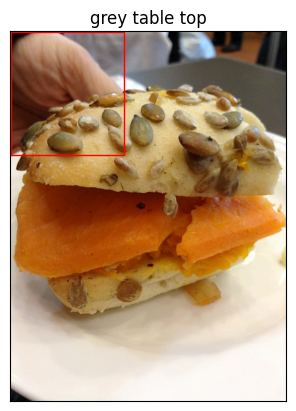

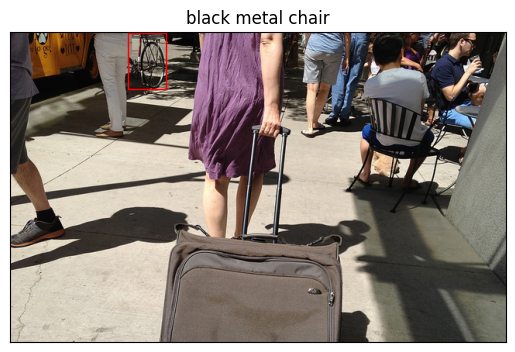

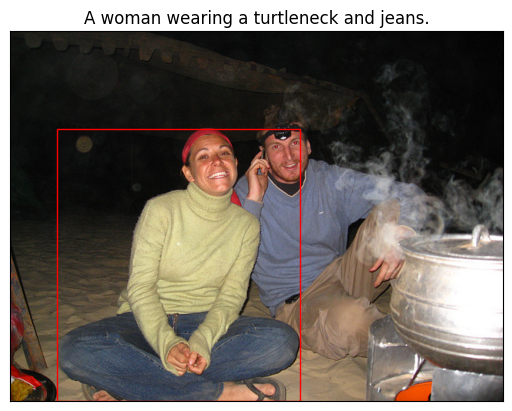

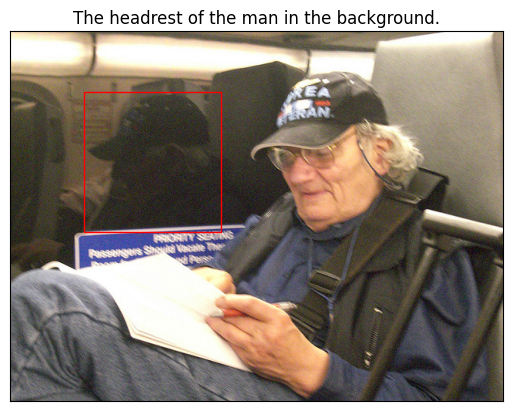

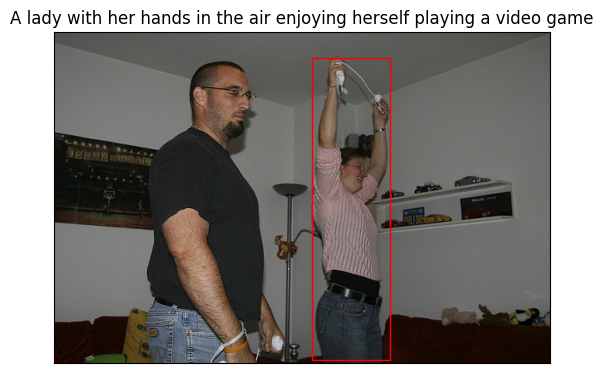

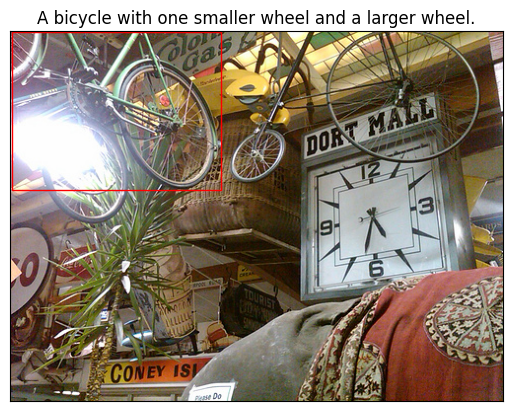

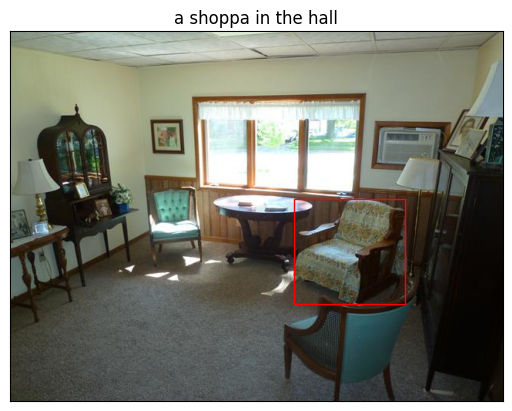

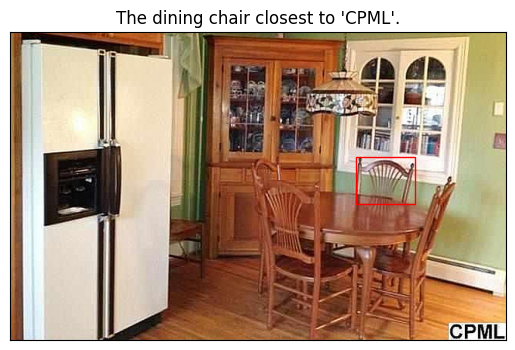

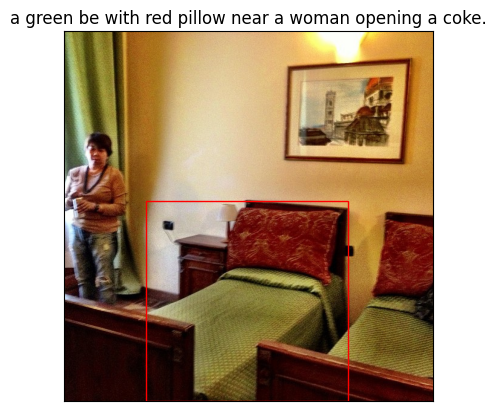

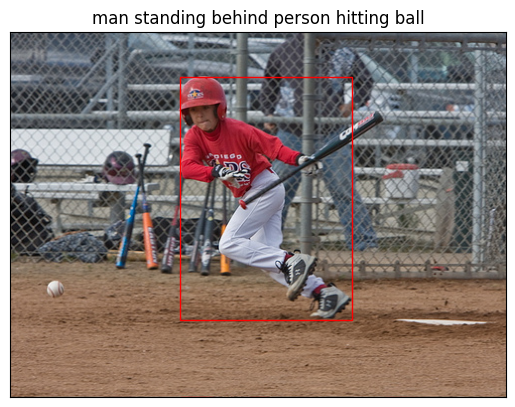

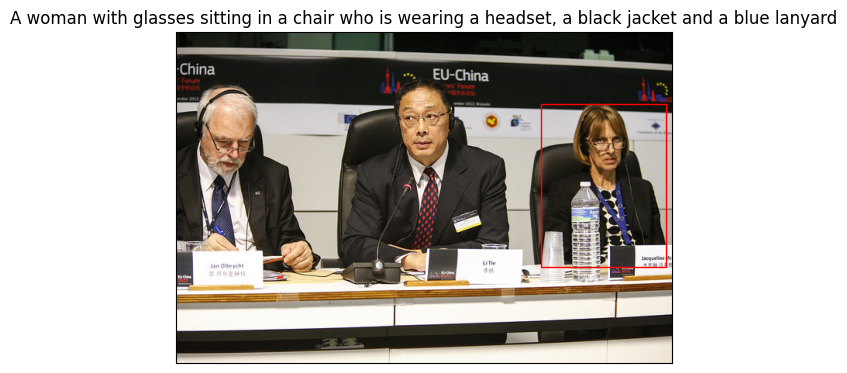

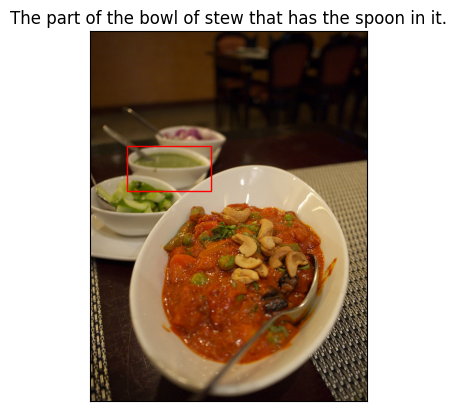

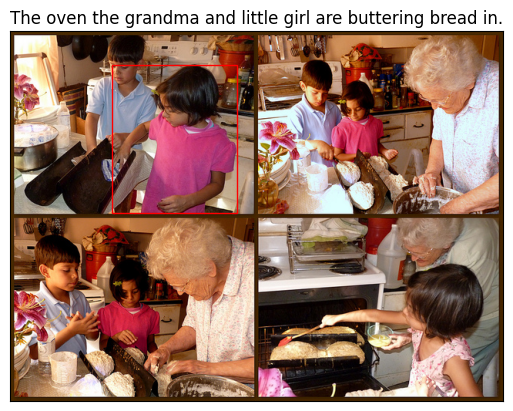

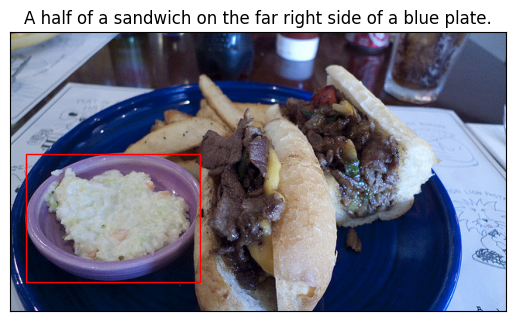

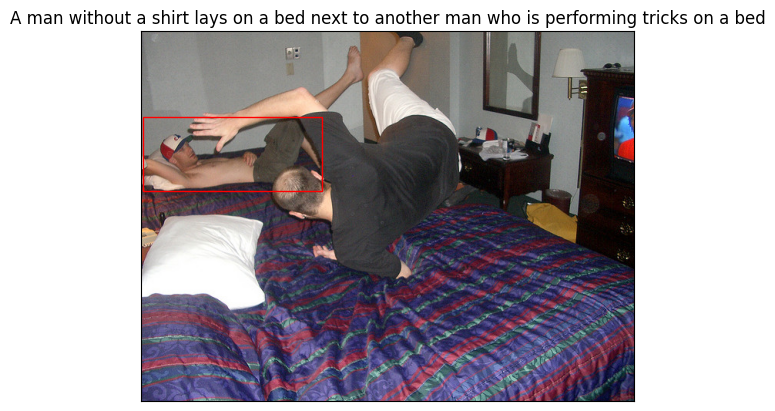

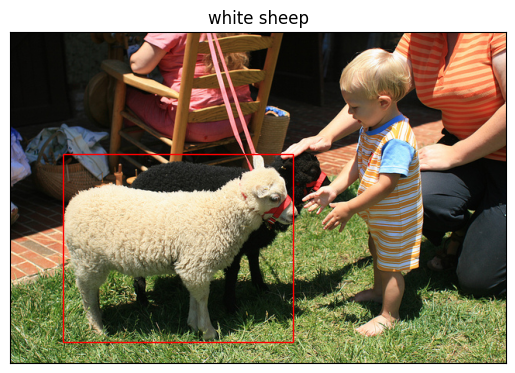

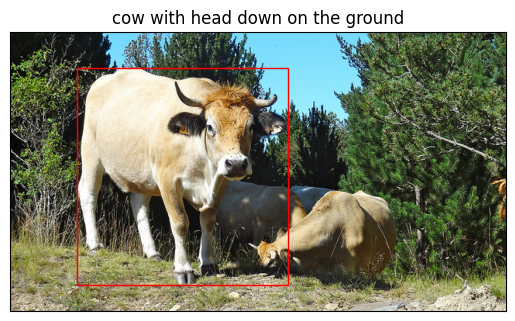

In [ ]:
images = [load_image_pil(i[0]) for i in path_imgs]
yolo_detector_module.plot_image_bbox(bboxes_pred, images, captions)

### 4 - TRAINING FREE SOLUTION - BLIP

Here we propose our training free solution for visual grounding by improving the baseline using pretrained BLIP as an Image Captioning model.

The main idea is to find objects with Yolo and generate a caption of every image crop containing the found objects. The generated caption that is the most similar to the original one, contains the right object.

In order to do so, we add the similarity scores obtained by Cosine Similarity between the original caption and the generated ones to the scores obtained in the baseline:

$$
BLIPscore_{i} = CLIPscore_{i} + CosineSimilarity(originalCaption, generatedCaption_i)
$$

Then we take the highest score, and return the relative Bounding Box. Unfortunately this promising solution turned out to be not as effective as the others, we report here the obtained results:

\

<center/>

**TABLE WITH THE METRICS: YOLO-CLIP-BLIP**


|                               |iou_m|acc@0.3|acc@0.5|acc@0.75|ap@0.3|ap@0.5|ap@0.75|ar@0.3|ar@0.5|ar@0.75|f1@0.3|f1@0.5|f1@0.75|
|----------------------------------|----------|--------------|--------------|---------------|-------------|-------------|--------------|----------|----------|-----------|------|------|-------|
|YoloCilpBlip|0.45|0.48 |0.43  | 0.41 |0.48 |0.43  | 0.41 |0.48 |0.43  | 0.41 |0.48 |0.43  | 0.41
|Baseline|0.55|0.59|0.55|0.52|0.59|0.55|0.52|0.59|0.55|0.52|0.59|0.55|0.52|

</center>

\


#### 4.1 - Imports

In [ ]:
import torch
from torch import nn
import cv2
import os

from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel
from ultralytics import YOLO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torchvision

#### 4.2 - Architecture

In [ ]:
class YoloClipBlip():
    def __init__(self, device):
        self.device = device
        self.yolo = torch.hub.load('ultralytics/yolov5', 'yolov5l6', pretrained=True).to(device)
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
        self.clipProcessor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
        self.blipProcessor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")


    def _detect_objects(self, image, yolo):
        """
        args:
            image: input image,
            yolo: YOLOv5l6 pretrained model

        returns:
            a list of blurred_out images
        """
        images = []
        bboxes = []
        results = yolo(image)

        def crop(img, bbox):
            img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2BGR)
            return img[int(bbox[1]):int(bbox[1])+int(bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]

        for bbox in results.xyxy[0].cpu().numpy():
            bboxes.append(bbox)
            images.append(crop(image, bbox))

        return images, bboxes


    def _generate_captions(self, images, blip, blipProcessor, device):
        """
        args:
            images: list of blurred_out images
            blip: BLIP-base pretrained model
            blipProcessor: BLIP processor
            device: torch.device # GPU/CPU

        returns:
            a list of captions, one for each image
        """
        captions = []
        for image in images:
            processed_image = blipProcessor(image, return_tensors="pt").to(device)
            out = blip.generate(**processed_image).to(device)
            captions.append(blipProcessor.decode(out[0], skip_special_tokens=True))
        return captions


    def _preprocess(self, images, caption, clipProcessor, device):
        """
        args:
            images: list of blurred_out images
            caption: text from RefCOCOg
            clipProcessor: CLIP processor
            device: torch.device # GPU/CPU

        returns:
            preprocessed images/captions
        """
        return clipProcessor(text=caption, images=images, return_tensors="pt", padding=True).to(device)


    def _image_text_matching(self, clip, **inputs):
        """
        args:
            clip: CLIP ViT-B/32 pretrained model
            inputs: preprocessed images/caption

        returns:
            logits/matching scores between images and caption
        """
        outputs = clip(**inputs)
        return outputs.logits_per_text.softmax(dim=1)


    def _caption_similarity(self, caption, blipCaptions, clipProcessor, device):
        """
        args:
            caption: original caption from RefCOCOg
            blipCaptions: captions generated by BLIP-base
            device: torch.device # GPU/CPU

        returns:
            a list of cosine similarity scores between the dataset caption and blipCaptions clip embeddings
        """
        caption_embeddings = clipProcessor(text=caption, return_tensors="pt", padding=True).to(device)

        results = []

        from torch.nn import CosineSimilarity
        cos = CosineSimilarity()  # Use dim=1 to calculate cosine similarity along the batch dimension

        for blipCaption in blipCaptions:
            blipCaption_embeddings = clipProcessor(text=blipCaption, return_tensors="pt", padding=True).to(device)

            tensor1 = blipCaption_embeddings["input_ids"].to(torch.float32)
            tensor2 = caption_embeddings["input_ids"].to(torch.float32)

            max_len = max(tensor1.shape[1], tensor2.shape[1])
            tensor1 = torch.nn.functional.pad(tensor1, (0, max_len - tensor1.shape[1]))
            tensor2 = torch.nn.functional.pad(tensor2, (0, max_len - tensor2.shape[1]))

            similarity = cos(tensor1, tensor2)
            results.append(similarity.item())

        return results


    def visual_grounding(self, image, caption):
        """
        args:
            image: np.array
            caption: string

        returns:
            the best bounding box.
        """
        images, bboxes = self._detect_objects(image=image, yolo=self.yolo)
        if len(bboxes) == 0:
            return [0.00, 0.00, 0.00, 0.00]
        preprocessed = self._preprocess(images=images, caption=caption, clipProcessor=self.clipProcessor, device=self.device)
        logits = self._image_text_matching(self.clip, **preprocessed)
        blipCaptions = self._generate_captions(images=images, blip=self.blip, blipProcessor=self.blipProcessor, device=self.device)
        caption_similarity = self._caption_similarity(caption=caption, blipCaptions=blipCaptions, clipProcessor=self.clipProcessor, device=self.device)
        results = logits.cpu().detach().numpy() + caption_similarity
        best_bbox = bboxes[np.argmax(results[0])]

        return best_bbox

    def _iou(self, box1, box2):
        """Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2]."""

        iou = torchvision.ops.box_iou(box1, box2)

        return iou

    def _get_metrics(self, box_pred, box_target):
        """Compute the accuracy, precision, recall and IoU."""
        mean_iou = []
        accuracy_0_3 = []
        accuracy_0_5 = []
        accuracy_0_75 = []
        conta = 0
        for b_t, b_p in zip(box_target, box_pred):

            IoU = self._iou(b_t.unsqueeze(0), b_p.unsqueeze(0))

            # get the iou
            # check if the IoU is between 0 and 1
            if IoU > -0.0001 and IoU < 1.0001:
                mean_iou.append(IoU)

                # get the accuracy
                if IoU > 0.3:
                    accuracy_0_3.append(1)
                else:
                    accuracy_0_3.append(0)

                if IoU > 0.5:
                    accuracy_0_5.append(1)
                else:
                    accuracy_0_5.append(0)

                if IoU > 0.75:
                    accuracy_0_75.append(1)
                else:
                    accuracy_0_75.append(0)

            else:
                pass

        # get the mean iou
        mean_iou_m = torch.stack(mean_iou).mean().numpy()

        # get the accuracy
        accuracy_0_3_m = np.array(accuracy_0_3).mean()
        accuracy_0_5_m = np.array(accuracy_0_5).mean()
        accuracy_0_75_m = np.array(accuracy_0_75).mean()

        # get precision
        precision_0_3 = np.array(accuracy_0_3).sum() / len(accuracy_0_3)
        precision_0_5 = np.array(accuracy_0_5).sum() / len(accuracy_0_5)
        precision_0_75 = np.array(accuracy_0_75).sum() / len(accuracy_0_75)

        # get recall
        recall_0_3 = np.array(accuracy_0_3).sum() / len(box_target)
        recall_0_5 = np.array(accuracy_0_5).sum() / len(box_target)
        recall_0_75 = np.array(accuracy_0_75).sum() / len(box_target)

        # get f1
        f1_0_3 = 2 * (precision_0_3 * recall_0_3) / (precision_0_3 + recall_0_3)
        f1_0_5 = 2 * (precision_0_5 * recall_0_5) / (precision_0_5 + recall_0_5)
        f1_0_75 = 2 * (precision_0_75 * recall_0_75) / (precision_0_75 + recall_0_75)


        return mean_iou_m, accuracy_0_3_m, accuracy_0_5_m, accuracy_0_75_m, precision_0_3, precision_0_5, precision_0_75, recall_0_3, recall_0_5, recall_0_75, f1_0_3, f1_0_5, f1_0_75

    def _get_dict_with_scores(self, mean_iou_m, accuracy_0_3_m, accuracy_0_5_m, accuracy_0_75_m, precision_0_3, precision_0_5, precision_0_75, recall_0_3, recall_0_5, recall_0_75, f1_0_3, f1_0_5, f1_0_75):
        """Return a dictionary with the scores"""
        return {
                'mean_iou_m': mean_iou_m.round(2),
                'accuracy_0_3_m': accuracy_0_3_m.round(2),
                'accuracy_0_5_m': accuracy_0_5_m.round(2),
                'accuracy_0_75_m': accuracy_0_75_m.round(2),
                'precision_0_3': precision_0_3.round(2),
                'precision_0_5': precision_0_5.round(2),
                'precision_0_75': precision_0_75.round(2),
                'recall_0_3': recall_0_3.round(2),
                'recall_0_5': recall_0_5.round(2),
                'recall_0_75': recall_0_75.round(2),
                'f1_0_3': f1_0_3.round(2),
                'f1_0_5': f1_0_5.round(2),
                'f1_0_75': f1_0_75.round(2)
            }


    def evaluation(self, dataset):

        from tqdm import tqdm

        best_bboxes = []
        refcocog_bboxes = []

        # Use tqdm to create a progress bar
        for d in tqdm(dataset, desc="Evaluating dataset", unit="image"):
            best_bboxes.append(self.visual_grounding(image=d["file_name"], caption=d["caption"]))
            refcocog_bboxes.append(d["bbox"])

        # save bboxes for faster evaluation afterwards
        np.save('./best_bboxes.npy', np.stack(np.array(best_bboxes)))
        np.save('./refcocog_bboxes.npy', np.stack(np.array(refcocog_bboxes)))

        # get the metrics
        mean_iou_m, accuracy_0_3_m, accuracy_0_5_m, accuracy_0_75_m, precision_0_3, precision_0_5, precision_0_75, recall_0_3, recall_0_5, recall_0_75, f1_0_3, f1_0_5, f1_0_75 = self._get_metrics(torch.from_numpy(best_bboxes), torch.from_numpy(refcocog_bboxes))

        # get the dictionary with the scores
        dict_with_scores = self._get_dict_with_scores(self, mean_iou_m, accuracy_0_3_m, accuracy_0_5_m, accuracy_0_75_m, precision_0_3, precision_0_5, precision_0_75, recall_0_3, recall_0_5, recall_0_75, f1_0_3, f1_0_5, f1_0_75)

        # convert the dictionary to a dataframe
        df = pd.DataFrame.from_dict(dict_with_scores, orient='index').T

        return df


#### 4.3 - Evaluation

In [ ]:
# Load refs and annotations
with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="test")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_clip_blip = YoloClipBlip(device)

yolo_clip_blip.evaluation(dataset)

### 5 - GRAPH CONTEXT ATTENTION

<center/>

**ARCHITECTURE**

</center>

\


![Imgur](https://i.imgur.com/oEilUJU.png)

\

1. The backbone uses the YoLOv8DetectorModule to extract the image-crops for each object in the image. Each image section is then processed into the correct format to be fed into the CLIP feature extractor. This module also pushes forward the coordinates of each bbox found by the detector.  

\

2. The CLIP feature extractor projects the target caption and the pre-processed image-crops onto the latent space.

\

3. Our Graph Detector module takes as input: the bboxes coordinates, the image-crops and the target caption projected into the CLIP latent space (BBoxesFeatures and TextFeatures).

  + The CLIPscoringWithScoreSorting shares the same mechanism with the rephrasing architecture. The only difference is the dot product between the BBoxesFeatures and the TextFeatures. In fact, with the rephrasing mechanism, the number of rows of TextFeatures is determined by the number of times we rephrase the target label. Here the dot product is between the BBoxesFeatures and the single target caption. Finally, we sort the BBoxesFeatures according to their scores. The output of the CLIPscoringWithScoreSorting module are the top-4 BBoxesFeatures and the corresponding CS scores.

  + In the figure, the CS scores are the vector of black boxes that have already been SoftMaxed. This allows it to be summed to one and to see the scores in terms of probabilities. The ContextAttentionModule takes as input the top-4 BBoxesFeatures and the CS matching scores with TextFeatures. In this module, we compute:
  
    -  The matching similarities between the top-4 BBoxesFeatures. The 4x4 matrix we get in the figure represents the similarities box by box.

    -  The matrix is flattened and fed to a transformer encoder. The transformer encoder uses the normalisation first strategy. To be specific, this strategy has been proved in the literature to improve overall convergence. We experimented with adding multiple transformer encoder layers to our model. However, we found that this made the training process more difficult and did not improve performance.

    -  We then transform the output into the original 4x4 dimension. A bilinear layer has the objective of performing the matching between the extracted feature of the context and the initial CS score.

    - The output of the bilinear is fed into an MLP. The MLP extracts a new set of scores which are added to the original matching scores. This guide the architecture in learning new bbox alternatives from the context of the best boxes. The non-linearity applied by the MLP is the ReLU activation function. The reason for applying this non-linearity is explained by its specific properties. Given that the output of the MLP is a score. If the score is negative, we set the value to zero. On the other hand, if it is positive, it is not changed.

  + As shown in the figure, the sum of the original and context scores is used to perform two activities. First, we sort the scores, as already discussed. Second, we perform a resizing of the top-1 bbox based on the matching scores.


\

\

Our aim was to improve the localization accuracy of object detection models. Below, we report the full table.

\

<center/>


**TABLE WITH THE METRICS: EVALUATION CONTEXT GRAPH MODULE WITH DIFFERENT BACKBONES**

\

|            |iou_m|acc@0.3|acc@0.5|acc@0.75|ap@0.3|ap@0.5|ap@0.75|ar@0.3|ar@0.5|ar@0.75|f1@0.3|f1@0.5|f1@0.75|
|---------------------------|------------------|--------------|--------------|---------------|-------------|-------------|--------------|----------|----------|-----------|------------|------------|-------------|
|gam_val_yolo_v5l6          |0.57              |0.62          |0.57          |0.54           |0.62         |0.57         |0.54          |0.6       |0.55      |0.53       |0.61        |0.56        |0.53         |
|gam_test_yolo_v5l6         |0.54              |0.58          |0.54          |0.52           |0.58         |0.54         |0.52          |0.58      |0.54      |0.51       |0.58        |0.54        |0.52         |
|gam_train_yolo_v5l6        |0.55              |0.59          |0.55          |0.52           |0.59         |0.55         |0.52          |0.59      |0.55      |0.52       |0.59        |0.55        |0.52         |
|gam_val_yolo_v5l6u         |0.58              |0.63          |0.59          |0.55           |0.63         |0.59         |0.55          |0.63      |0.58      |0.55       |0.63        |0.59        |0.55         |
|gam_test_yolo_v5l6u        |0.56              |0.6           |0.56          |0.53           |0.6          |0.56         |0.53          |0.6       |0.55      |0.52       |0.6         |0.56        |0.53         |
|gam_train_yolo_v5l6u       |0.57              |0.61          |0.57          |0.54           |0.61         |0.57         |0.54          |0.61      |0.57      |0.54       |0.61        |0.57        |0.54         |
|gam_val_yolo_v5x6u         |0.57              |0.62          |0.57          |0.53           |0.62         |0.57         |0.53          |0.61      |0.57      |0.53       |0.62        |0.57        |0.53         |
|gam_test_yolo_v5x6u        |0.57              |0.62          |0.57          |0.54           |0.62         |0.57         |0.54          |0.61      |0.56      |0.53       |0.62        |0.57        |0.54         |
|gam_val_yolo_v8x           |0.56              |0.61          |0.56          |0.53           |0.61         |0.56         |0.53          |0.6       |0.56      |0.52       |0.61        |0.56        |0.52         |
|gam_test_yolo_v8x          |0.56              |0.6           |0.55          |0.53           |0.6          |0.55         |0.53          |0.6       |0.55      |0.52       |0.6         |0.55        |0.52         |

</center>

\



##### 5.1 - Imports

In [ ]:
import os
import numpy as np
import pandas as pd


import pickle
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO


#### 5.2 - Utils

In [ ]:
def load_image_plt(path):
    """ Load image with matplotlib"""
    return plt.imread(path)

def load_image_pil(path):
    """ Load image with PIL"""
    return Image.open(path)


def get_distance_box_iou_accuracy(box_pred, box_true, iou_threshold=0.5):
    """
    Given the target boxes and the prediction return the
    accuracy of the prediction. The accuracy is computed as
    the percentage of boxes that have an IoU > iou_threshold
    with the target box.

    Args:
    @params box_pred: tensor of shape (batch_size, n_boxes, 4)
    @params box_true: tensor of shape (batch_size, n_boxes, 4)
    @params iou_threshold: float

    Returns:
    @params accuracy: float

    """

    iou = torchvision.ops.box_iou(box_pred, box_true).diagonal()
    giou = torchvision.ops.generalized_box_iou(box_pred, box_true).diagonal()

    return (iou > iou_threshold).float().mean(), iou.mean(), giou.mean()

#### 5.3 - Modules

In [ ]:
# Constants and models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# YOLO
model_yolo = YOLO("yolov8x.pt")

# CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

##### 5.3.0 - CLIP Score calculator

In [ ]:
class CLIPscoreBlock(nn.Module):
    '''
    This block compute the bached clip score for each box.
    The input is the text embedding and the box embedding.
    The output is a tensor of shape (batch_size, n_boxes, 1)
    where each element is the score of the box.

    Args:
        @params text_emb: tensor of shape (batch_size, 512)
        @params box_emb: tensor of shape (batch_size, n_boxes, 512)

    Returns:
        @params returns x: tensor of shape (batch_size, n_boxes, 1)

    x:  [tex_0 @ box_1.T, tex_0 @ box_2.T, ..., tex_0 @ box_j]
        [tex_1 @ box_1.T, tex_1 @ box_2.T, ..., tex_1 @ box_j]
        [tex_2 @ box_1.T, tex_2 @ box_2.T, ..., tex_2 @ box_j]
                                ...
                                ...
        [tex_i @ box_1.T, tex_i @ box_2.T, ..., tex_i @ box_j]

    I am normalizing over the rows and summing over the columns
    to get the overall score for each box.

    x summarize the matching in between the sentence and the boxes
    x: [sum(tex_[:] @ box_1.T), sum(tex_[:] @ box_2.T), ..., sum(tex_[:] @ box_j)]
    '''
    def __init__(self, n_box=48):
        super().__init__()
        self.n_box = n_box


    def forward(self, box_encoding, text_emb):

        x = torch.bmm(text_emb.squeeze(-1), box_encoding) # (B, D) @ (B, D)

        # I should sum over the row to get the total score for each box.
        # Specifically, I sum the probability of each box being the target
        # box according to the text encoding match score.
        x = x.sum(dim=-2)

        return x

##### 5.3.1 - Context Attention Module

In [ ]:
class ContextAttentionModule(nn.Module):
    def __init__(self, dim_embedding, max_num_boxes = 3, temperature = 1.0, n_head=2, number_transformer_layers=1, hidden = 384) -> None:
        super().__init__()

        self.dim_embedding = dim_embedding
        self.num_boxes = max_num_boxes
        self.temperature = temperature
        self.hidden = hidden

        self.W = nn.Bilinear(max_num_boxes, 1, self.hidden)

        self.W1 = nn.Linear(self.hidden, 1)

        self.gelu = nn.GELU()
        self.relu = nn.ReLU()

        self.layernorm = nn.LayerNorm(self.hidden)

        # In our architecture the transformer encoder has the layer norm first.
        # According with the results of the paper 'On Layer Normalization in
        # the Transformer Architecture' the convergence is faster with the layer
        # norm first.
        # source: https://arxiv.org/pdf/2002.04745.pdf
        self.transformer_encoder = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(d_model=self.num_boxes*self.num_boxes, nhead=n_head, norm_first=True, batch_first=True), num_layers=number_transformer_layers
            )


    def forward(self, x, matching):

        x = x.squeeze(-3)

        # the score over the last dim should sum to one
        c_s = F.softmax(torch.bmm(x.permute(0, 2, 1), x), dim=-1)

        c_s = c_s.flatten(start_dim=-2, end_dim=-1)

        c_s = self.transformer_encoder(c_s) # (B, D)

        c_s = c_s.reshape(c_s.shape[0], self.num_boxes, self.num_boxes)

        # combine the attention score
        # with the matching score
        x = self.W(c_s, matching) # (B, D)
        del c_s

        x = self.gelu(x)
        x = self.layernorm(x)

        x = self.W1(x) # (B, D)
        x = self.relu(x)

        return x

##### 5.3.2 - Graph Detector Module

In [ ]:
class GraphDetectorModule(nn.Module):
    def __init__(self, dim_embedding = 512, max_num_boxes = 3, hidden_resizing_operator=16) -> None:
        super().__init__()

        self.dim_embedding = dim_embedding
        self.max_num_boxes = max_num_boxes

        self.clipScoreBlock = CLIPscoreBlock()

        self.gam = ContextAttentionModule(dim_embedding, max_num_boxes)

        self.resizing_operator = nn.Sequential(
            nn.Linear(1, hidden_resizing_operator),
            nn.GELU(),
            nn.LayerNorm(hidden_resizing_operator),
            nn.Linear(hidden_resizing_operator, 4),
            nn.ReLU()
        )

    def forward(self, text_feat, x, boxes):


        # compute the matching score
        x_1 = self.clipScoreBlock(x[:,0,:,:], text_feat)

        # sort the boxes according to the matching score
        _, idx = torch.sort(x_1, dim=1, descending=True)
        x = x.gather(3, idx.unsqueeze(-2).unsqueeze(-2).repeat(1, 1, 512, 1))[:,:,:,:self.max_num_boxes]
        x_1 = x_1.gather(1, idx)[:,:self.max_num_boxes].unsqueeze(-1)
        boxes = boxes.gather(1, idx.unsqueeze(-1).repeat(1, 1, 4))[:,:self.max_num_boxes]


        # apply the graph attention modulation
        x = self.gam(x, x_1) # (B, D)

        # The score in output from the gam model represents
        # the matching score between the boxes considering
        # also the context. The context refers to the other
        # boxes.
        x = x + x_1

        # concatenate the boxes to the embedding
        x = torch.cat([x, boxes], dim = -1) # (batch_size, self.max_num_boxes, 1 + 4)

        # sort the boxes according with the score
        _, idx = torch.sort(x[:, :, 0], dim=1, descending=True)
        x = x.gather(1, idx.unsqueeze(-1).repeat(1, 1, 5))[:, 0, :]

        resize = self.resizing_operator(x[:,0].unsqueeze(-1))

        return resize + x[:,1:]

##### 5.3.3 - Graph Detector Module

In [ ]:
class GraphDetectorModuleLightning(pl.LightningModule):
    def __init__(self, dim_embedding = 512, max_num_boxes = 4) -> None:
        super().__init__()

        self.dim_embedding = dim_embedding
        self.max_num_boxes = max_num_boxes

        self.gam_l = GraphDetectorModule(dim_embedding, max_num_boxes)

        self.HUBER = nn.SmoothL1Loss()

        self.accuracy = get_distance_box_iou_accuracy

        # self.MSE = nn.MSELoss()
        # self.MAE = nn.L1Loss()
        # GENERALIZED_BOX_IOU_LOSS https://arxiv.org/abs/1902.09630
        # self.generalized_box_iou_loss = torchvision.ops.generalized_box_iou_loss
        # DISTANCE_BOX_IOU_LOSS https://arxiv.org/abs/1911.08287
        # self.distance_box_iou_loss = torchvision.ops.distance_box_iou_loss
        # COMPLETE_BOX_IOU_LOSS https://arxiv.org/abs/1911.08287
        # self.complete_box_iou_loss = torchvision.ops.complete_box_iou_loss


    def forward(self,text_feat, x, boxes):
        return self.gam_l(text_feat, x, boxes)

    def training_step(self, batch, batch_idx):

        text_feat, x, boxes, target = batch

        pred = self(text_feat, x, boxes)

        # keep track of the losses

        huber_loss = self.HUBER(pred, target)

        accuracy, mean_iou, mean_giou = self.accuracy(pred, target)

        self.log('train_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_mean_iou', mean_iou, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('train_mean_giou', mean_giou, on_step = True, on_epoch = True, prog_bar = True, logger = True)


        return huber_loss * (1.4 - mean_iou)

    def validation_step(self, batch, batch_idx):

        text_feat, x, boxes, target = batch

        pred = self(text_feat, x, boxes)

        # keep track of the losses

        huber_loss = self.HUBER(pred, target)

        accuracy, mean_iou, mean_giou = self.accuracy(pred, target)

        self.log('val_huber_loss', huber_loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('val_accuracy', accuracy, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('val_mean_iou', mean_iou, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.log('val_mean_giou', mean_giou, on_step = True, on_epoch = True, prog_bar = True, logger = True)

        return huber_loss * (1.4 - mean_iou)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr = 0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20)
        return [optimizer], [scheduler]

##### 5.3.4 - YOLOv8 Detector Module

In [ ]:
class YOLOv8DetectorModule(nn.Module):
    def __init__(self, model, preprocess, device):
        super(YOLOv8DetectorModule, self).__init__()
        self.model_yolo = model
        self.preprocess = preprocess
        self.device = device

        # image normalization
        # mean-std input image normalization
        self.transform = transforms.Compose([
                                transforms.Resize(800),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])

    def get_crops(self, yolov8_df, image):
        """ Get crops of the image from yolov8_df

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            list: crops

        """
        crops = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]

            if confidence > 0.5:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))
                crops.append(crop)

        # add the entire image
        crops.append(Image.fromarray(image))

        return crops

    def get_crops_preprocessed_for_clip(self, yolov8_df, image):
        """ Get crops from yolov8_df and preprocess them for CLIP

        Args:
            yolov8_df (pd.DataFrame): DataFrame with yolov5 predictions
            image (np.array): image as np.array

        Returns:
            torch.tensor: preprocessed crops

        """
        crops = []
        boxes = []
        image = image

        for box in yolov8_df.values:
            x_min, y_min, x_max, y_max, confidence = box[:5]
            # print(x_min, y_min, x_max, y_max, confidence)
            if confidence > 0.3:
                crop = image[int(y_min):int(y_max), int(x_min):int(x_max)]
                crop = Image.fromarray((crop * 255).astype(np.uint8))#.convert('RGB')
                crop = self.preprocess(crop)
                crops.append(crop)
                boxes.append(torch.tensor([x_min, y_min, x_max, y_max]).type(torch.float32).unsqueeze(0))

        # add the entire image
        # crops.append(self.preprocess(Image.fromarray(image)))

        return torch.stack(crops).to(self.device), torch.cat(boxes).to(self.device)

    def plot_image_yolov8(self, results, image):
        """Plot the images with the boxes"""
        for i in results.xyxy[0]:
            if i[4] > 0.5: # if confidence is greater than 0.5
                # Create figure and axes
                _, ax = plt.subplots()

                boxes = i[:4]

                # Display the image
                ax.imshow(image)

                # Create a Rectangle patch
                x_min, y_min, width, height = boxes.tolist()
                ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)

                plt.show()

    def plot_image_bbox(self, boxes, images, captions):
        """Plot the images with the boxes"""
        for bbox, image, c in zip(boxes.tolist(), images, captions):
              # Create figure and axes
              _, ax = plt.subplots()

              # Display the image
              ax.imshow(image)

              # Create a Rectangle patch
              x_min, y_min, width, height = bbox
              ax.add_patch(Rectangle((x_min, y_min), width-x_min, height-y_min, linewidth=1, edgecolor='r', facecolor='none'))

              ax.axes.xaxis.set_visible(False)
              ax.axes.yaxis.set_visible(False)

              plt.title(c[0])

              plt.show()

    def forward(self, images_path):

        print('Detecting objects in the images...')
        # get yolov8 predictions
        results = self.model_yolo([load_image_pil(i) for i in images_path])

        print('Boxes detected!')

        # store the predictions into a dataframe
        results = [pd.DataFrame(result.boxes.boxes.tolist(), columns=['x_min', 'y_min', 'x_max', 'y_max', 'confidence', 'class']) for result in results]

        print('Preprocessing crops with CLIP...')

        # preprocess the images for CLIP
        cropPreprocessed_boxes = [
            self.get_crops_preprocessed_for_clip(yolov8_df, image)
                    for yolov8_df, image in zip(results, [load_image_plt(i) for i in images_path])
                ]

        imgs_preproc = [i[0] for i in cropPreprocessed_boxes]
        yolo_boxes = [i[1] for i in cropPreprocessed_boxes]

        if len(yolo_boxes) == 1:
            yolo_boxes = yolo_boxes[0].unsqueeze(0).to(torch.float32)
            imgs_preproc = imgs_preproc[0].unsqueeze(0).to(torch.float32)
        else:
            yolo_boxes = torch.cat(yolo_boxes).to(torch.float32)
            imgs_preproc = torch.cat(imgs_preproc).to(torch.float32)

        return imgs_preproc, yolo_boxes

#### 5.4 - Complete architecture class

In [ ]:
class CLIP_GraphDetectorModule(nn.Module):
    def __init__(self, clip_model, clip_tokenizer, yolo_module, finetuned_model, device):
        super().__init__()

        self.clip_model = clip_model
        self.clip_tokenizer = clip_tokenizer
        self.yolo_module = yolo_module
        self.finetuned_model = finetuned_model
        self.device = device

    def get_image_features(self, images):
        """Get the clip image features"""

        print('Encoding images...')

        with torch.no_grad():
            image_features = self.clip_model.encode_image(images)
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features

    def get_text_features(self, text):
        """Get the clip text features"""

        print('Encoding text...')

        with torch.no_grad():
            text_features = self.clip_model.encode_text(self.clip_tokenizer([t for t in text]).to(device))
        # Normalize features
        text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    def get_score_similarities(self, image_features, text_features):
        """Get the clip similarities"""
        # Compute the score similarities
        similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        return similarities

    def detector_inference(self, images):
        # get preprocessed crops of the objects
        # in the original images
        x = [self.yolo_module(image) for image in images]
        max_crop_shape = max([crop[1].shape[1] for crop in x])
        imgs_crops, yolo_boxes = [crop[0] for crop in x], torch.cat([torch.nn.functional.pad(crop[1], (0, 0, max_crop_shape-crop[1].shape[1], 0)) for crop in x])
        return imgs_crops, yolo_boxes

    def box_norm_rescale(self, box_target):
        """ Rescale the box_target
        Args:
            box_target: (number of samples, 1, 4)

        Returns:
            box_target: (number of samples, 1, 4)

        """
        # convert the box_pred to x1, y1, x2, y2
        box_target[:, 0, 2] = box_target[:, 0, 0] + box_target[:, 0, 2]
        box_target[:, 0, 3] = box_target[:, 0, 1] + box_target[:, 0, 3]

        return box_target

    def forward(self, x, captions):
        # get the preprocessed crops of the objects in
        # the original images
        imgs_crops, yolo_boxes = self.detector_inference(x)

        print('Extracting features with CLIP...')

        # extract the clip text features
        if len(captions) == 1:
            caption_features = self.get_text_features(captions).unsqueeze(-1).unsqueeze(1).to(torch.float32)
        else:
            caption_features = torch.stack(
                [self.get_text_features(caption) for caption in captions]
            ).unsqueeze(-1).to(torch.float32)

        # extract the clip image features
        images_features = [self.get_image_features(img_crops.squeeze(0)).unsqueeze(0) for img_crops in imgs_crops]
        max_shape = max([crops.shape[1] for crops in images_features])
        images_features = torch.cat([torch.nn.functional.pad(crops, (0, 0, max_shape-crops.shape[1], 0)) for crops in images_features]).permute(0, 2, 1).unsqueeze(1).to(torch.float32)


        print('Prepare the data...')

        # check that the number of boxes are > 4
        if yolo_boxes.shape[-2] < 4:
            # padd the image features
            images_features = F.pad(images_features, (0, 0, 0, 0, 0, 4 - yolo_boxes.shape[-2]))

        yolo_boxes = self.box_norm_rescale(yolo_boxes)

        pred = self.finetuned_model(caption_features, images_features, yolo_boxes)

        return pred

#### 5.5 - Usage

In [ ]:
!gdown 1NotFDnBpb6O9qO1VXWlH5Vs5j4wknY9E

In [ ]:
yolo_detector_module = YOLOv8DetectorModule(model_yolo, clip_preprocess, device).to(device)
fine_tuned_model = GraphDetectorModuleLightning().to(device)
fine_tuned_model = fine_tuned_model.load_from_checkpoint('model-simplified_gam-epoch=50-val_loss=0.00-v1.ckpt')

model_finetuned = CLIP_GraphDetectorModule(clip_model, clip.tokenize, yolo_detector_module, fine_tuned_model, device)

# count the number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad)/1000000} M")


dataset = RefCOCOg(refs, annotations, split="test")
# dataset = RefCOCOg(refs, annotations, split="val")

interval = np.arange(30, 3000, 10)

path_imgs = [[dataset[i]['file_name']] for i in interval]
captions = [[dataset[i]['caption']] for i in interval]


bboxes_pred = model_finetuned(path_imgs, captions).detach().cpu()

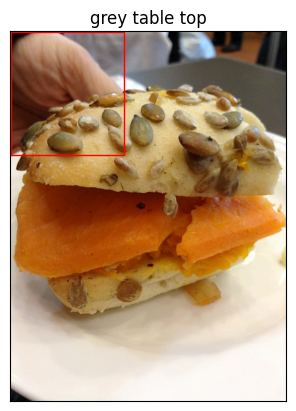

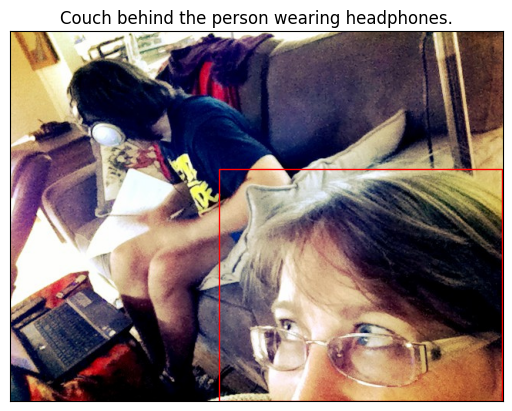

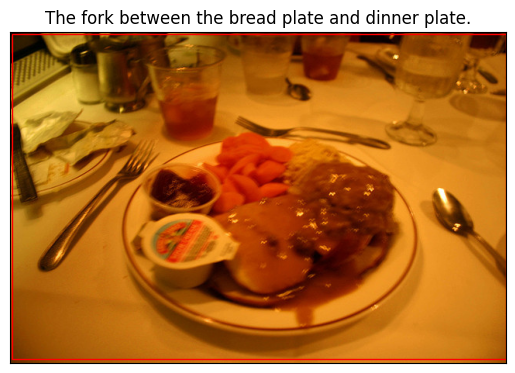

In [ ]:
images = [load_image_pil(i[0]) for i in path_imgs]
yolo_detector_module.plot_image_bbox(bboxes_pred, images, captions)

## Plug&Play Evaluation



This cell's purpose is to initiate the download and execution of the evaluation script. Through this script, we will obtain the models' checkpoint as well as the precomputed datasets featuring various backbones. Once the evaluation is complete, the output will present the evaluation results.

\

<center/>

**PLOT EVALUATION**

</center>


The plot below shows the score of different solutions based on different backbones. The X-axis is the scores and the Y-axis is the evaluation across different solutions. The visualization aims to compare the score difference and to check if some detectors perform better than others. If the score is affected by the variance, is highlighted by the shadow between the line. This measure  how much the evaluations deviate from the expected value. Our proposed solutions enhance performance, as shown by the results.

\

![Imgur](https://i.imgur.com/Zcm51OZ.png)

\

![Imgur](https://i.imgur.com/XNcViSe.png)

\

![Imgur](https://i.imgur.com/XeFGSSg.png)

\

---
Legend:
+ IoU m: Mean intersection over union
+ acc: Accuracy
+ ap: Average Precision
+ ar: Average Recall
+ f1: F1 score

In [ ]:
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1Obq6-ApHB9dzxsmJ4Wj63aJE7rj0UDHl'
destination = 'eval.tar'

download_file_from_google_drive(file_id, destination)

!tar -xvf ./eval.tar eval.py
!python eval.py
!rm -rf eval.tar __MACOSX

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemDownloadedDate'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
eval.py

############################################################
##############################Downloading and unzipping data
############################################################

Downloading...
From: https://drive.google.com/uc?id=1l-eH5ycEUlZ05c39wzwg9no0skNxdy9i
To: /content/eval_yolo_clip_preprocessed.zip
100% 2.17G/2.17G [00:26<00:00, 81.9MB/s]

############################################################
######################